# **PROJECT TITLE: Yelp Ratings**

In [1]:
# Import packages
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Visualizing missingness
import missingno as msno
import statsmodels.api as sm


## **1. INTRODUCTION**

## **2. ABOUT THE DATA**

In [2]:
# Read the data
df = pd.read_csv("data/MSBA Exit_Yelp.csv")

# Preview the data
df.head()

,attributes,business_id,categories,city,hours,is_open,latitude,longitude,postal_code,review_count,state,stars
0,"{'ByAppointmentOnly': 'True', 'BusinessAccepts...",922049,"Home Organization, Interior Design, Profession...",Portland,"{'Monday': '0:0-0:0', 'Tuesday': '9:0-17:0', '...",1,45.551736,-122.552248,97220,11,OR,5.0
1,"{'WiFi': ""u'free'"", 'RestaurantsGoodForGroups'...",492976,"Burgers, Restaurants",Portland,"{'Monday': '11:0-20:0', 'Tuesday': '11:0-21:0'...",1,45.519562,-122.675040,97204,790,OR,4.0
2,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...",125987,"Home Services, Tree Services, Landscaping",Austin,"{'Monday': '8:0-18:0', 'Tuesday': '8:0-18:0', ...",1,30.296603,-97.970185,78738,6,TX,4.0
3,{'ByAppointmentOnly': 'True'},445542,"Chiropractors, Massage Therapy, Health & Medical",Portland,NaN,0,45.520668,-122.672014,97204,15,OR,5.0
4,"{'ByAppointmentOnly': 'True', 'BusinessAccepts...",225939,"Apartments, Real Estate, Home Services",Orlando,"{'Monday': '9:0-18:0', 'Tuesday': '10:0-18:0',...",0,28.520020,-81.457009,32811,7,FL,4.5


In [3]:
# Shape of the dataset
df.shape

(120437, 12)

In [4]:
# Columns inspection
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120437 entries, 0 to 120436
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   attributes    109193 non-null  object 
 1   business_id   120437 non-null  int64  
 2   categories    120351 non-null  object 
 3   city          120437 non-null  object 
 4   hours         99879 non-null   object 
 5   is_open       120437 non-null  int64  
 6   latitude      120437 non-null  float64
 7   longitude     120437 non-null  float64
 8   postal_code   120355 non-null  object 
 9   review_count  120437 non-null  int64  
 10  state         120437 non-null  object 
 11  stars         120437 non-null  float64
dtypes: float64(3), int64(3), object(6)
memory usage: 11.0+ MB


## **3. DATA PREPARATION FOR EXPLORATORY DATA ANALYSIS**

This section focus on preparing the data for visualization and exploratory data analysis. Note that we are not dropping any missing values in this section but rather creating additional columns that we will help us create the visualization we want to explore.

#### 3.1. The Hour Column

Create additional columns for the original Hour column. The first column tell us on which days these businesses are closed, the second one shows whether they are closed on Weekends, and the last one tells us how many operating hour in a week.

In [5]:
# Function to evaluate closing status based on hours
def evaluate_closing_status(hours):
    if pd.isnull(hours):
        return "unknown"

    try:
        hours_dict = json.loads(hours.replace("'", '"'))
        closed_days = [day for day, time in hours_dict.items() if time == '0:0-0:0']
        
        if 'Sunday' in closed_days and len(closed_days) == 1:
            return "closed on sunday"
        elif 'Saturday' in closed_days and len(closed_days) == 1:
            return "closed on saturday"
        elif 'Saturday' in closed_days and 'Sunday' in closed_days:
            return "closed on week-ends"
        else:
            week_days_closed = [day for day in closed_days if day in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']]
            if week_days_closed:
                return f"closed on {len(week_days_closed)} week day(s)"
            return "open all week"
    except:
        return "unknown"

# Apply the function to the hours column
df['closing_status'] = df['hours'].apply(evaluate_closing_status)


In [6]:
# Display the resulting dataframe
df[['business_id', 'hours', 'closing_status']].head()

,business_id,hours,closing_status
0,922049,"{'Monday': '0:0-0:0', 'Tuesday': '9:0-17:0', '...",closed on 1 week day(s)
1,492976,"{'Monday': '11:0-20:0', 'Tuesday': '11:0-21:0'...",open all week
2,125987,"{'Monday': '8:0-18:0', 'Tuesday': '8:0-18:0', ...",open all week
3,445542,NaN,unknown
4,225939,"{'Monday': '9:0-18:0', 'Tuesday': '10:0-18:0',...",open all week


In [7]:
# Function to calculate total hours and check weekend hours
def process_hours(hours_data):
    if pd.isna(hours_data):
        # Handle NaN values by returning default values
        return 0, False

    # Convert string to dictionary if necessary
    if isinstance(hours_data, str):
        hours_dict = eval(hours_data)
    else:
        hours_dict = hours_data
    
    total_hours = 0
    weekend_open = False
    for day, hours in hours_dict.items():
        open_time, close_time = hours.split('-')
        open_hour, open_minute = map(int, open_time.split(':'))
        close_hour, close_minute = map(int, close_time.split(':'))
        
        # Calculate hours for the day
        daily_hours = (close_hour + close_minute / 60) - (open_hour + open_minute / 60)
        if daily_hours > 0:
            total_hours += daily_hours
            
        # Check for weekend hours
        if day in ['Saturday', 'Sunday'] and daily_hours > 0:
            weekend_open = True
    
    return total_hours, weekend_open

df_1 = df.copy()
# Apply the function to the DataFrame
df_1[['Total Weekly Hours', 'Weekend Hours']] = df_1['hours'].apply(lambda x: process_hours(x)).apply(pd.Series)

In [8]:
df_1.head()

,attributes,business_id,categories,city,hours,is_open,latitude,longitude,postal_code,review_count,state,stars,closing_status,Total Weekly Hours,Weekend Hours
0,"{'ByAppointmentOnly': 'True', 'BusinessAccepts...",922049,"Home Organization, Interior Design, Profession...",Portland,"{'Monday': '0:0-0:0', 'Tuesday': '9:0-17:0', '...",1,45.551736,-122.552248,97220,11,OR,5.0,closed on 1 week day(s),48.0,True
1,"{'WiFi': ""u'free'"", 'RestaurantsGoodForGroups'...",492976,"Burgers, Restaurants",Portland,"{'Monday': '11:0-20:0', 'Tuesday': '11:0-21:0'...",1,45.519562,-122.675040,97204,790,OR,4.0,open all week,69.0,True
2,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...",125987,"Home Services, Tree Services, Landscaping",Austin,"{'Monday': '8:0-18:0', 'Tuesday': '8:0-18:0', ...",1,30.296603,-97.970185,78738,6,TX,4.0,open all week,60.0,True
3,{'ByAppointmentOnly': 'True'},445542,"Chiropractors, Massage Therapy, Health & Medical",Portland,NaN,0,45.520668,-122.672014,97204,15,OR,5.0,unknown,0.0,False
4,"{'ByAppointmentOnly': 'True', 'BusinessAccepts...",225939,"Apartments, Real Estate, Home Services",Orlando,"{'Monday': '9:0-18:0', 'Tuesday': '10:0-18:0',...",0,28.520020,-81.457009,32811,7,FL,4.5,open all week,55.0,True


#### 3.2. The Attributes Column

This section extracts different features by found in the Attributes column in order to create new columns from them. These include and not limited to features such as **RestaurantsGoodForGroups**, **BusinessAcceptsCreditCards**, **WiFi**, and more.

In [9]:
import ast

# Function to convert stringified dictionary to actual dictionary
def parse_dict_string(dict_string):
    if pd.isna(dict_string):
        return {}
    return ast.literal_eval(dict_string)

# Apply the function to the column
df_parsed = df_1['attributes'].apply(parse_dict_string)

# Create a DataFrame from the parsed dictionaries, using pd.json_normalize to handle different keys across rows
df_expanded = pd.json_normalize(df_parsed)

# Concatenate the original DataFrame with the expanded DataFrame
df_2 = pd.concat([df_1, df_expanded], axis=1)

# Drop the original 'BusinessAttributes' column if you no longer need it
df_2.drop(columns=['attributes'], inplace=True)

In [10]:
df_2.head()

,business_id,categories,city,hours,is_open,latitude,longitude,postal_code,review_count,state,...,Music,Smoking,AcceptsInsurance,BYOBCorkage,BYOB,Corkage,DietaryRestrictions,RestaurantsCounterService,Open24Hours,AgesAllowed
0,922049,"Home Organization, Interior Design, Profession...",Portland,"{'Monday': '0:0-0:0', 'Tuesday': '9:0-17:0', '...",1,45.551736,-122.552248,97220,11,OR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,492976,"Burgers, Restaurants",Portland,"{'Monday': '11:0-20:0', 'Tuesday': '11:0-21:0'...",1,45.519562,-122.675040,97204,790,OR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,125987,"Home Services, Tree Services, Landscaping",Austin,"{'Monday': '8:0-18:0', 'Tuesday': '8:0-18:0', ...",1,30.296603,-97.970185,78738,6,TX,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,445542,"Chiropractors, Massage Therapy, Health & Medical",Portland,NaN,0,45.520668,-122.672014,97204,15,OR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,225939,"Apartments, Real Estate, Home Services",Orlando,"{'Monday': '9:0-18:0', 'Tuesday': '10:0-18:0',...",0,28.520020,-81.457009,32811,7,FL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Check for missing values in the data with the new columns
df_2.isnull().sum() / len(df_2) * 100

business_id                    0.000000
categories                     0.071407
city                           0.000000
hours                         17.069505
is_open                        0.000000
latitude                       0.000000
longitude                      0.000000
postal_code                    0.068085
review_count                   0.000000
state                          0.000000
stars                          0.000000
closing_status                 0.000000
Total Weekly Hours             0.000000
Weekend Hours                  0.000000
ByAppointmentOnly             69.099197
BusinessAcceptsCreditCards    25.106902
BusinessAcceptsBitcoin        88.988434
WiFi                          63.255478
RestaurantsGoodForGroups      71.637454
GoodForKids                   64.544949
RestaurantsAttire             74.549349
BikeParking                   52.433222
NoiseLevel                    75.486769
OutdoorSeating                68.671588
RestaurantsPriceRange2        42.486113


#### **3.3. The Category Column**

In this section we organize the category column into main business categories. This is very critical in helping us to build our model.

In [12]:
# Define a mapping of detailed categories to main categories
category_mapping = {
    'Restaurant': ['Restaurant', 'Food', 'Burgers', 'Pizza', 'Chinese', 'Mexican', 'Italian', 'Sushi', 'Cafe', 'Bakery'],
    'Manufacturing': ['Manufacturing', 'Factory', 'Industrial'],
    'Real Estate': ['Real Estate', 'Apartments', 'Property Management'],
    'Health': ['Health', 'Medical', 'Dentists', 'Doctors', 'Chiropractors'],
    'Beauty': ['Beauty', 'Salons', 'Spa', 'Nail Salons', 'Hair Salons'],
    'Home Services': ['Home Services', 'Landscaping', 'Plumbing', 'Electricians'],
    'Retail': ['Retail', 'Shopping', 'Clothing', 'Electronics', 'Books'],
    'Entertainment': ['Entertainment', 'Cinema', 'Theater', 'Concerts'],
    'Fitness': ['Fitness', 'Gym', 'Yoga', 'Personal Training'],
    'Education': ['Education', 'School', 'College', 'University', 'Tutoring'],
    # Add more main categories and detailed categories as needed
}

# Function to map detailed categories to main categories
def get_main_category(categories):
    if pd.isnull(categories):
        return 'Other'
    for main_category, detailed_categories in category_mapping.items():
        if any(cat in categories for cat in detailed_categories):
            return main_category
    return 'Other'

# Apply the function to create a new column for the main category
df_2['main_category'] = df_2['categories'].apply(get_main_category)


In [13]:
# Display the first few rows of the DataFrame to verify the new column
print(df_2[['categories', 'main_category']].head())

                                          categories  main_category
0  Home Organization, Interior Design, Profession...  Home Services
1                               Burgers, Restaurants     Restaurant
2          Home Services, Tree Services, Landscaping  Home Services
3   Chiropractors, Massage Therapy, Health & Medical         Health
4             Apartments, Real Estate, Home Services    Real Estate


<Axes: >

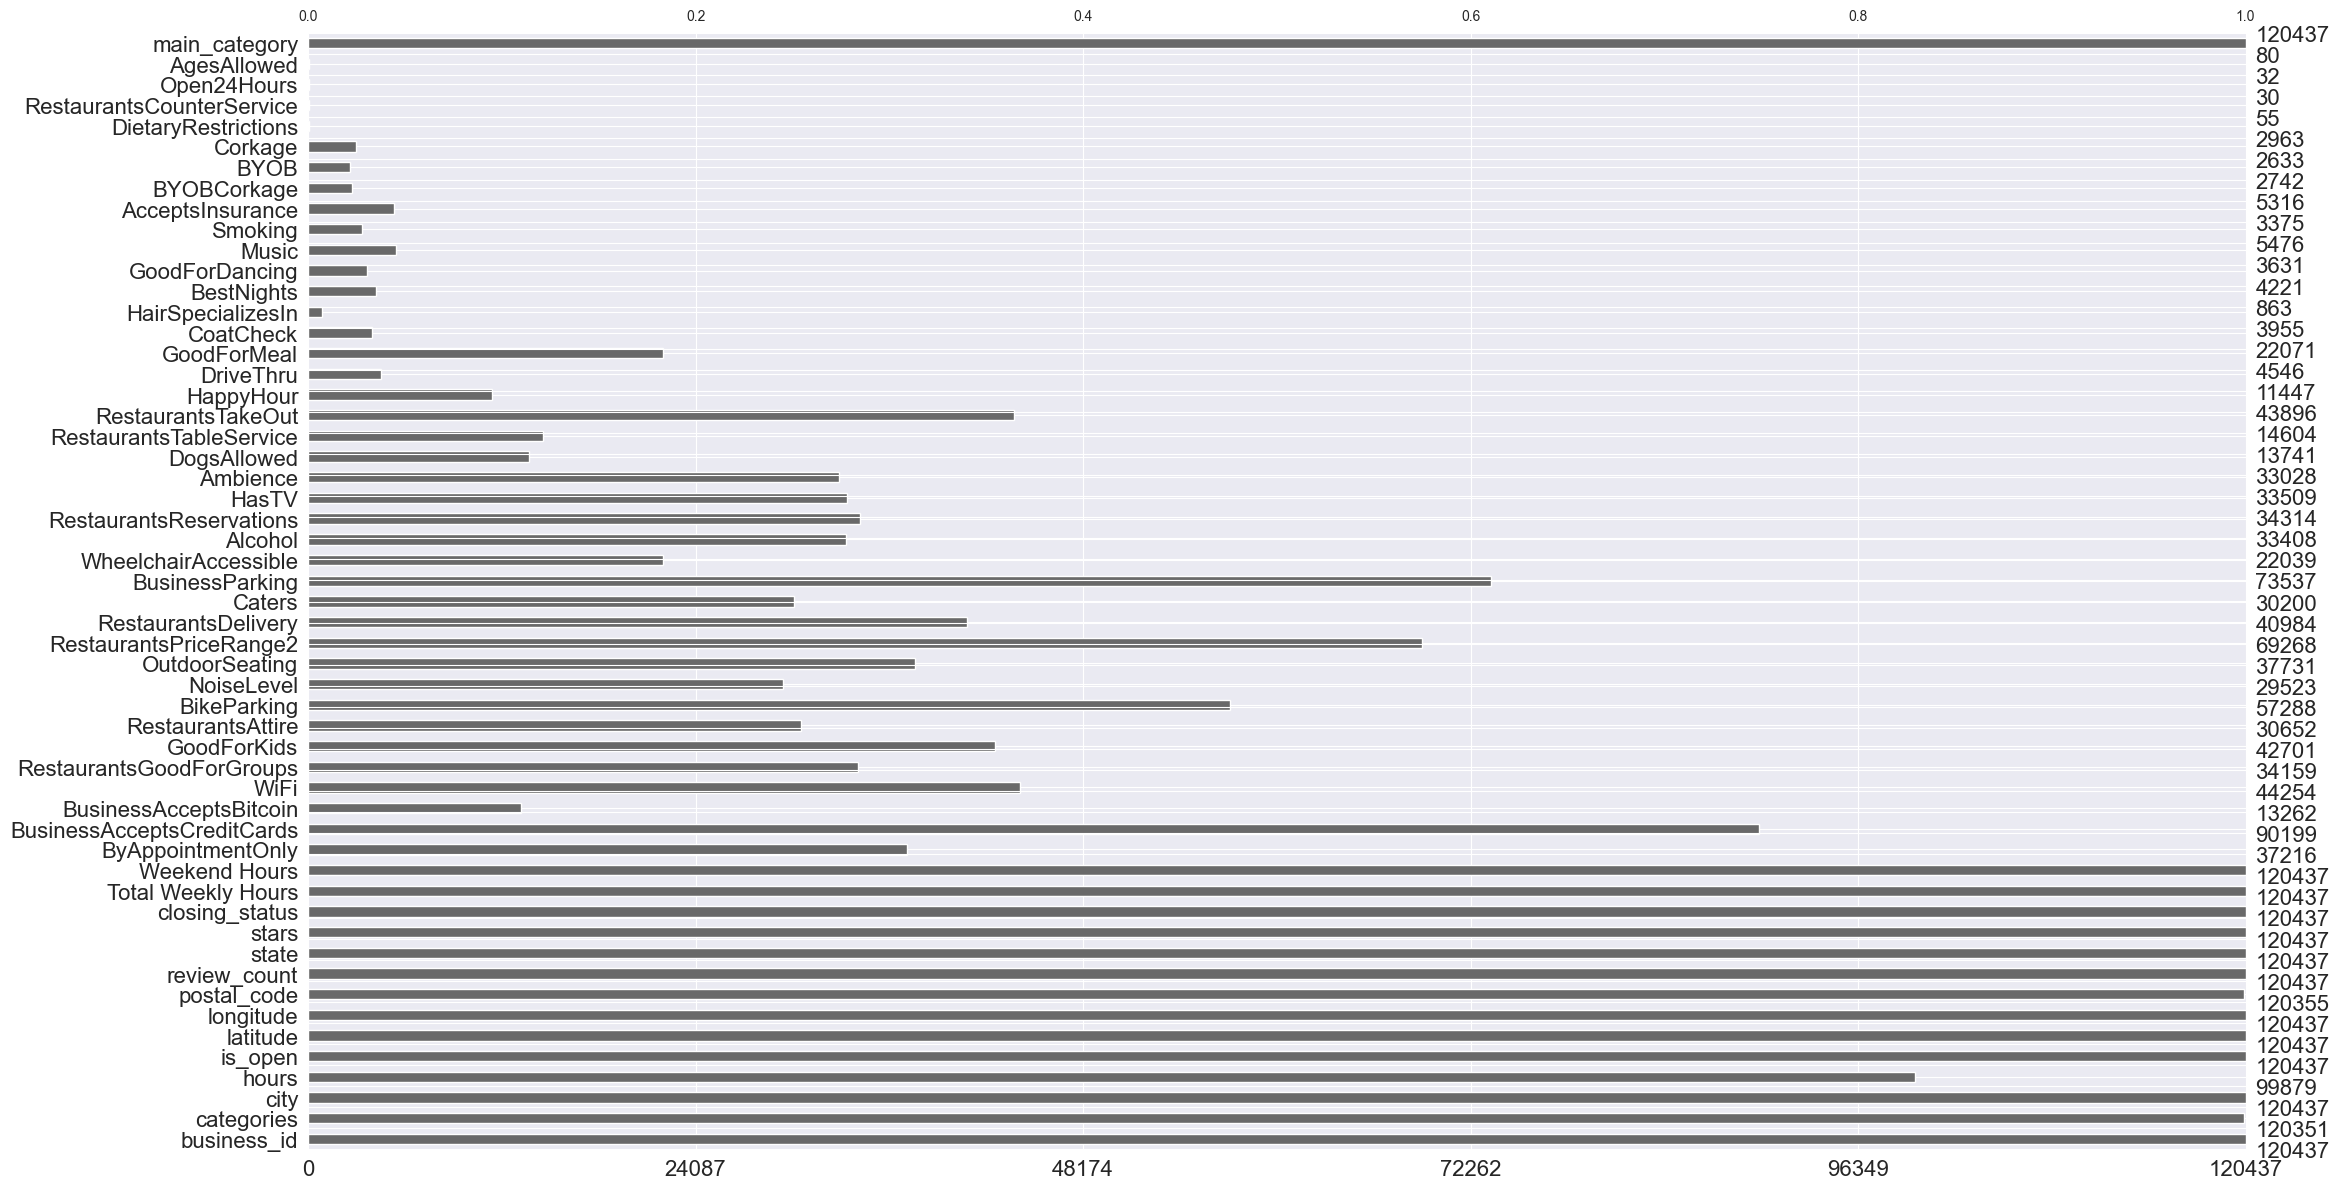

In [17]:
# Plot amount of missingness
msno.bar(df_2)

## **4. Exploratory Data**

#### **4.1. Overall Visualizations**

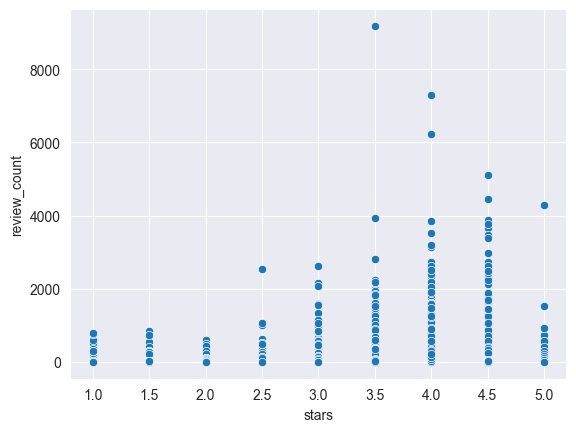

In [30]:
# Relationship between average star ratings and review counts
sns.scatterplot(df_2, x="stars", y="review_count")

plt.show()

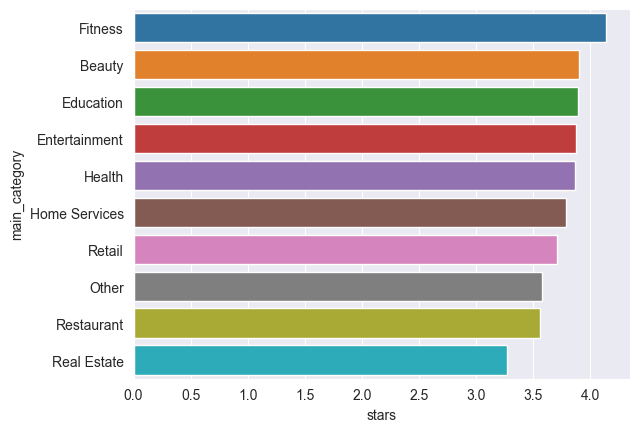

In [20]:
# Average star ratings by Main Categories
main_category_ratings = df_2.groupby('main_category')[['stars']].mean().reset_index().sort_values(by='stars', ascending=False)

# The visualization
sns.barplot(x="stars", y="main_category", data=main_category_ratings)

plt.show()

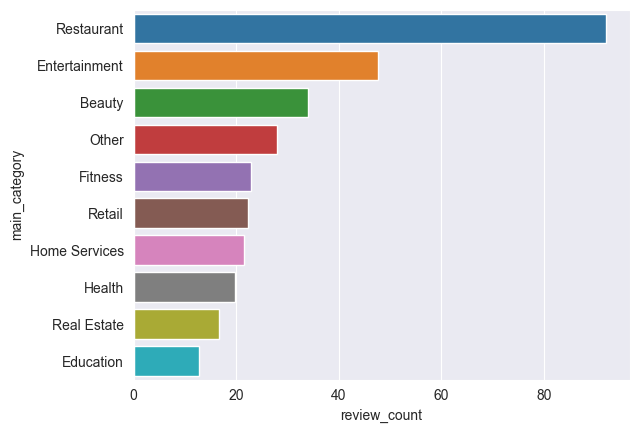

In [21]:
# Total review counts by Main Categories
main_category_ratings = df_2.groupby('main_category')[['review_count']].mean().reset_index().sort_values(by='review_count', ascending=False)

# The visualization
sns.barplot(x="review_count", y="main_category", data=main_category_ratings)

plt.show()

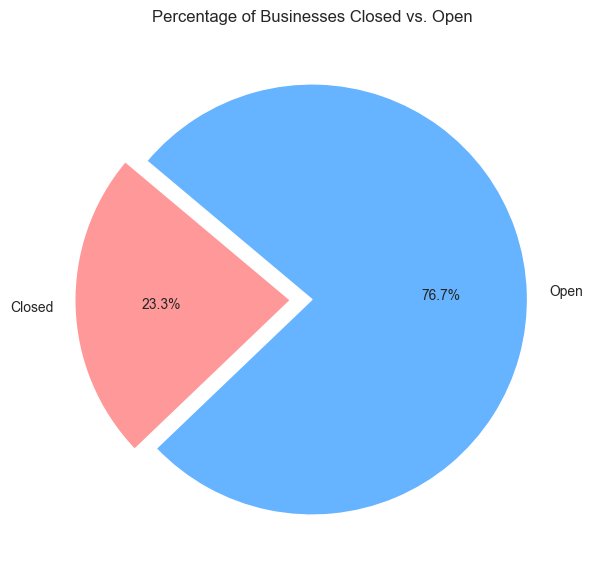

In [24]:
# Calculate the percentage
open_count = df_2['is_open'].value_counts(normalize=True) * 100
closed_percentage = open_count[0]
open_percentage = open_count[1]

# Data for visualization
labels = ['Closed', 'Open']
sizes = [closed_percentage, open_percentage]
colors = ['#ff9999','#66b3ff']
explode = (0.1, 0)  # explode the 'Closed' slice

# Plotting the pie chart
plt.figure(figsize=(7,7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Businesses Closed vs. Open')
plt.show()

#### **4.2. Separated Main Categories**

##### 4.2.1. Restaurants

In [29]:
df_2.loc[(df_2['main_category'] == 'Restaurant') & (df_2['RestaurantsDelivery'] != 'None')].groupby('RestaurantsDelivery')[['stars']].mean().reset_index().sort_values(by='stars', ascending=False)

,RestaurantsDelivery,stars
0,False,3.605253
1,True,3.449979


## **Split into Main Categories**

In [17]:
df_2.main_category.unique()

array(['Home Services', 'Restaurant', 'Health', 'Real Estate', 'Beauty',
       'Other', 'Retail', 'Fitness', 'Entertainment', 'Education'],
      dtype=object)

### Restaurant

In [69]:
df_restaurant = df_2[df_2['main_category'] == 'Restaurant']

In [20]:
df_restaurant.shape

(48368, 54)

<Axes: >

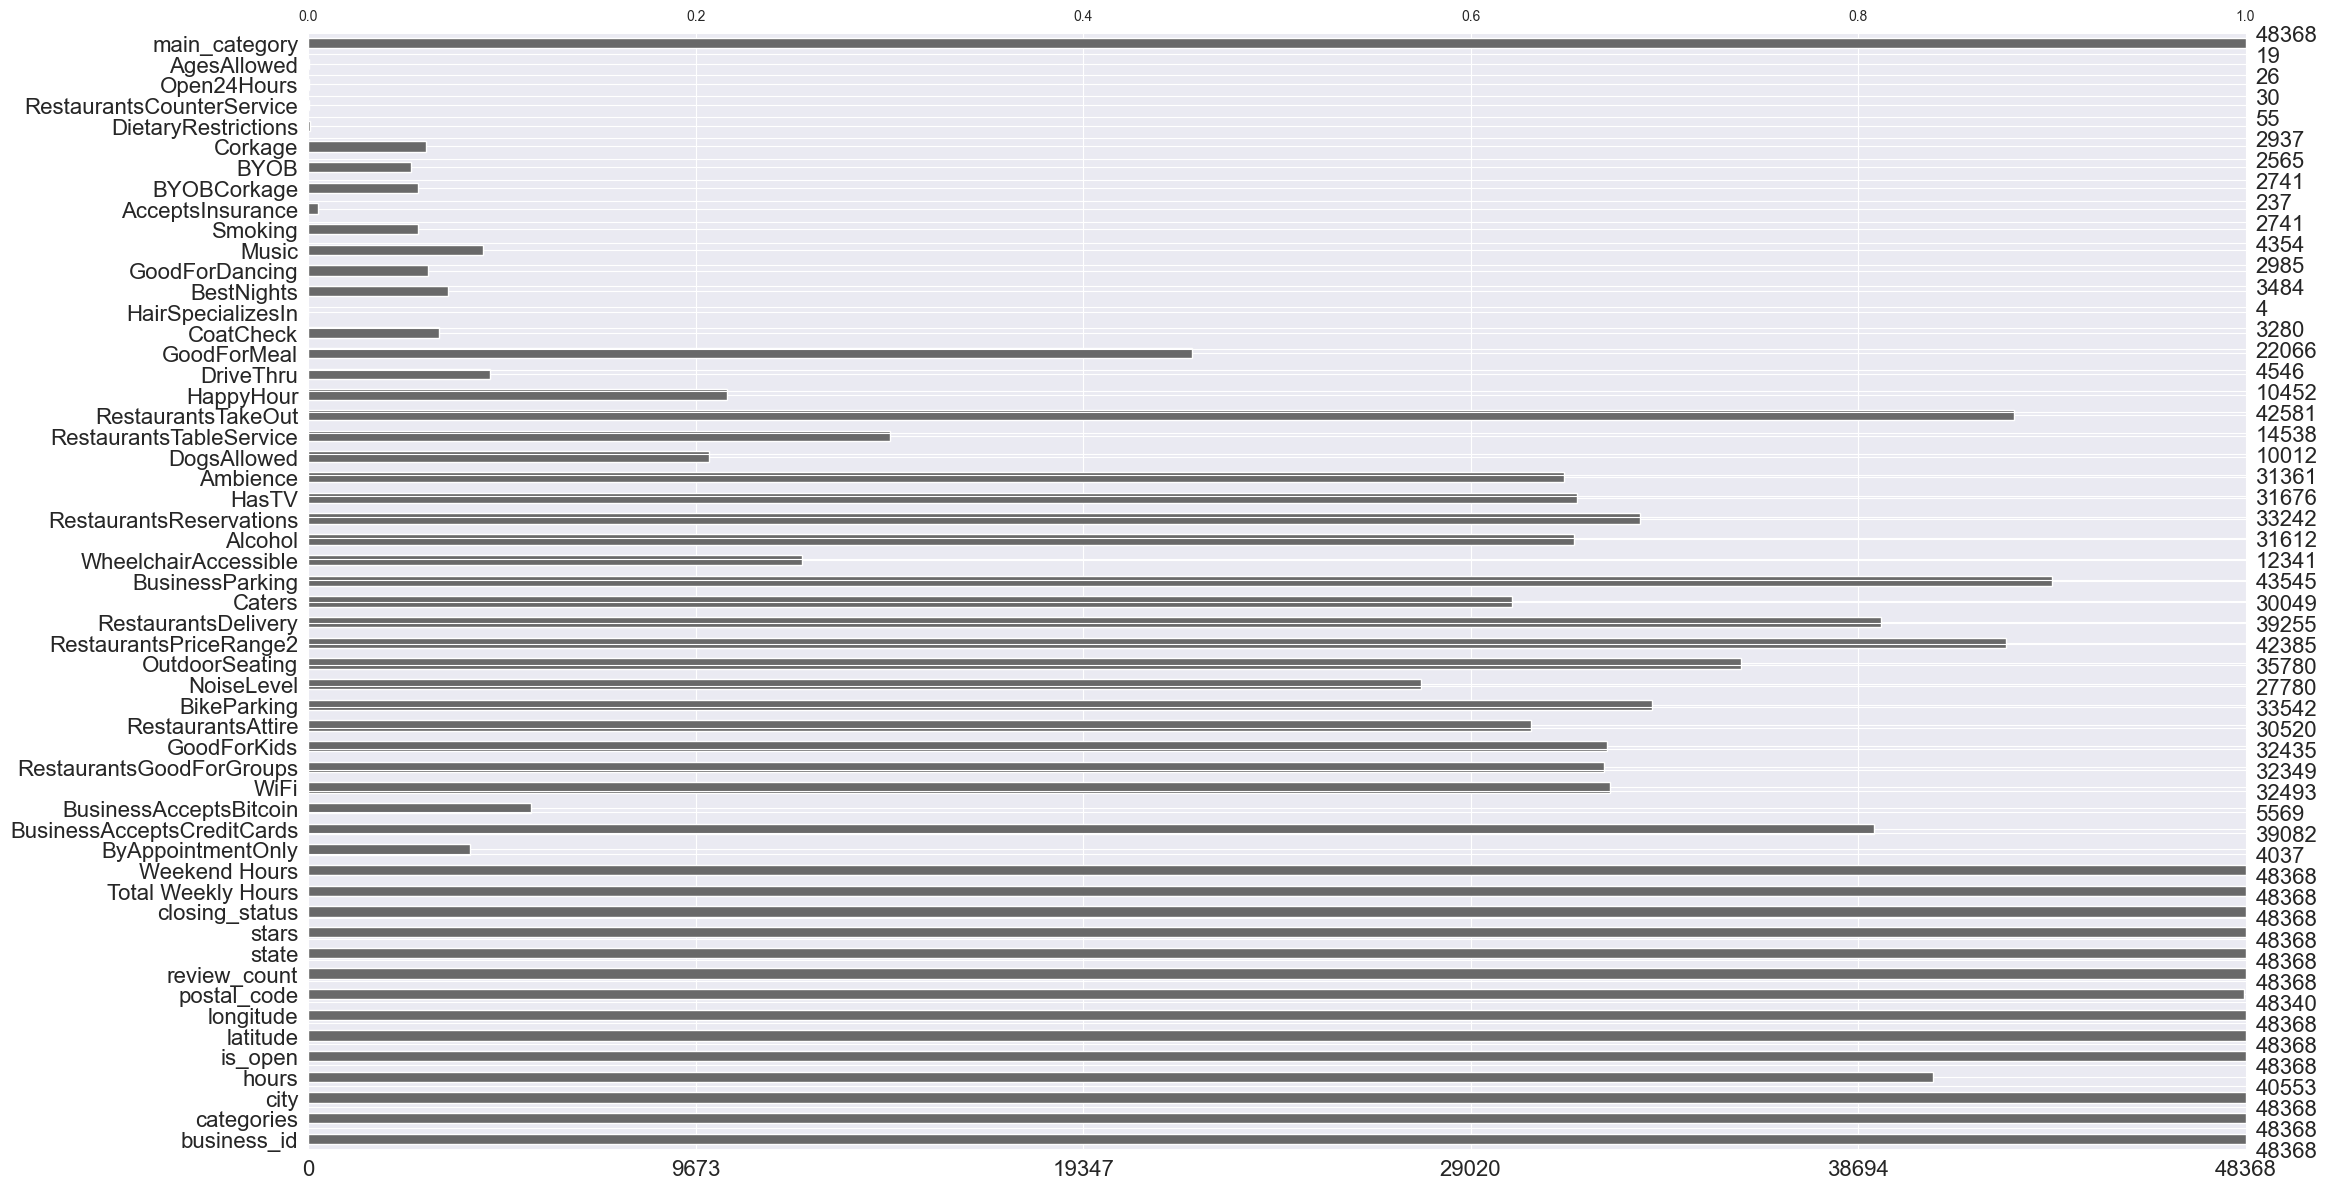

In [19]:
msno.bar(df_restaurant)

##### Select columns

In [39]:
restaurant_columns = ['is_open', 'review_count', 'stars', 'Weekend Hours', 'BusinessAcceptsCreditCards', 'WiFi', 'RestaurantsGoodForGroups', 'GoodForKids', 'OutdoorSeating', 'NoiseLevel', 'RestaurantsDelivery', 'RestaurantsReservations', 'RestaurantsTakeOut']

In [40]:
df_restaurant = df_restaurant[restaurant_columns]

In [41]:
df_restaurant.head()

,is_open,review_count,stars,Weekend Hours,BusinessAcceptsCreditCards,WiFi,RestaurantsGoodForGroups,GoodForKids,OutdoorSeating,NoiseLevel,RestaurantsDelivery,RestaurantsReservations,RestaurantsTakeOut
1,1,790,4.0,True,True,u'free',True,True,True,'loud',True,False,True
6,1,14,3.0,True,NaN,NaN,NaN,NaN,NaN,u'average',NaN,NaN,NaN
8,1,16,4.5,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1,72,3.0,False,True,'no',True,False,True,u'loud',None,False,True
12,1,118,4.5,True,True,'no',True,True,False,u'average',False,False,True


##### Data Preparation

In [ ]:
# Wifi
df_restaurant.loc[df_restaurant['WiFi'] == "u'free'"] = "free"
df_restaurant.loc[df_restaurant['WiFi'] == "'free'"] = "free"
df_restaurant.loc[df_restaurant['WiFi'] == "u'no'"] = "no"
df_restaurant.loc[df_restaurant['WiFi'] == "'no'"] = "no"
df_restaurant.loc[df_restaurant['WiFi'] == "u'paid'"] = "paid"
df_restaurant.loc[df_restaurant['WiFi'] == "'paid'"] = "paid"
df_restaurant.loc[df_restaurant['WiFi'] == 'None'] = np.nan

In [43]:
# Wifi
df_restaurant['WiFi'] = df_restaurant['WiFi'].replace("u'free'", "free").replace("'free'", "free").replace("u'no'", "no").replace("'no'", "no").replace("u'paid'", "paid").replace("'paid'", "paid").replace('None', np.nan)

/var/folders/pb/_fq6py6n40x8n9_jp1pqrp0w0000gn/T/ipykernel_2545/1023130388.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_restaurant['WiFi'] = df_restaurant['WiFi'].replace("u'free'", "free").replace("'free'", "free").replace("u'no'", "no").replace("'no'", "no").replace("u'paid'", "paid").replace("'paid'", "paid").replace('None', np.nan)


In [44]:
df_restaurant.WiFi.unique()

array(['free', nan, 'no', 'paid'], dtype=object)

In [45]:
# Noise Level
df_restaurant['NoiseLevel'] = df_restaurant['NoiseLevel'].replace("'loud'", "loud").replace("u'loud'", "loud").replace("u'average'", "average").replace("'average'", "average").replace("u'quiet'", "quiet").replace("'quiet'", "quiet").replace("u'very_loud'", "very_loud").replace("'very_loud'", "very_loud").replace('None', np.nan)

/var/folders/pb/_fq6py6n40x8n9_jp1pqrp0w0000gn/T/ipykernel_2545/2833120392.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_restaurant['NoiseLevel'] = df_restaurant['NoiseLevel'].replace("'loud'", "loud").replace("u'loud'", "loud").replace("u'average'", "average").replace("'average'", "average").replace("u'quiet'", "quiet").replace("'quiet'", "quiet").replace("u'very_loud'", "very_loud").replace("'very_loud'", "very_loud").replace('None', np.nan)


In [46]:
df_restaurant.NoiseLevel.unique()

array(['loud', 'average', nan, 'quiet', 'very_loud'], dtype=object)

In [47]:
df_restaurant.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48368 entries, 1 to 120436
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   is_open                     48368 non-null  int64  
 1   review_count                48368 non-null  int64  
 2   stars                       48368 non-null  float64
 3   Weekend Hours               48368 non-null  bool   
 4   BusinessAcceptsCreditCards  39082 non-null  object 
 5   WiFi                        32465 non-null  object 
 6   RestaurantsGoodForGroups    32349 non-null  object 
 7   GoodForKids                 32435 non-null  object 
 8   OutdoorSeating              35780 non-null  object 
 9   NoiseLevel                  27767 non-null  object 
 10  RestaurantsDelivery         39255 non-null  object 
 11  RestaurantsReservations     33242 non-null  object 
 12  RestaurantsTakeOut          42581 non-null  object 
dtypes: bool(1), float64(1), int64(2), o

**Replace the 'None'**

In [48]:
for col in df_restaurant.columns:
    df_restaurant[col] = df_restaurant[col].replace('None', np.nan).replace(True, 1).replace(False, 0).replace('True', 1).replace('False', 0)

/var/folders/pb/_fq6py6n40x8n9_jp1pqrp0w0000gn/T/ipykernel_2545/3718498639.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_restaurant[col] = df_restaurant[col].replace('None', np.nan).replace(True, 1).replace(False, 0).replace('True', 1).replace('False', 0)


In [50]:
df_restaurant.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48368 entries, 1 to 120436
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   is_open                     48368 non-null  int64  
 1   review_count                48368 non-null  int64  
 2   stars                       48368 non-null  float64
 3   Weekend Hours               48368 non-null  int64  
 4   BusinessAcceptsCreditCards  39076 non-null  float64
 5   WiFi                        32465 non-null  object 
 6   RestaurantsGoodForGroups    32341 non-null  float64
 7   GoodForKids                 32424 non-null  float64
 8   OutdoorSeating              33993 non-null  float64
 9   NoiseLevel                  27767 non-null  object 
 10  RestaurantsDelivery         37504 non-null  float64
 11  RestaurantsReservations     33105 non-null  float64
 12  RestaurantsTakeOut          41726 non-null  float64
dtypes: float64(8), int64(3), object(2)


In [51]:
df_restaurant.shape

(48368, 13)

In [52]:
# Cleaned data
df_restaurant_cleaned = df_restaurant.dropna()

In [53]:
df_restaurant_cleaned.shape

(18081, 13)

In [56]:
features_restaurant = df_restaurant_cleaned.drop(columns=['stars'])

In [57]:
X_restaurant = pd.get_dummies(features_restaurant, columns=['WiFi', 'NoiseLevel'], drop_first=True)

In [58]:
y_restaurant = df_restaurant_cleaned['stars']

In [63]:
X_restaurant.columns

Index(['is_open', 'review_count', 'Weekend Hours',
       'BusinessAcceptsCreditCards', 'RestaurantsGoodForGroups', 'GoodForKids',
       'OutdoorSeating', 'RestaurantsDelivery', 'RestaurantsReservations',
       'RestaurantsTakeOut', 'WiFi_no', 'WiFi_paid', 'NoiseLevel_loud',
       'NoiseLevel_quiet', 'NoiseLevel_very_loud'],
      dtype='object')

In [64]:
for col in ['WiFi_no', 'WiFi_paid', 'NoiseLevel_loud', 'NoiseLevel_quiet', 'NoiseLevel_very_loud']:
    X_restaurant[col] = X_restaurant[col].astype('int')

In [65]:
# Add a constant to the model (intercept)
X_sm_restaurant = sm.add_constant(X_restaurant)

In [66]:
# Fit the OLS model
model_restaurant = sm.OLS(y_restaurant, X_sm_restaurant).fit()

In [67]:
# Print the summary of the regression
print(model_restaurant.summary())

                            OLS Regression Results                            
Dep. Variable:                  stars   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     208.3
Date:                Mon, 12 Aug 2024   Prob (F-statistic):               0.00
Time:                        03:23:01   Log-Likelihood:                -17654.
No. Observations:               18081   AIC:                         3.534e+04
Df Residuals:                   18065   BIC:                         3.547e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

### Home Services

In [70]:
df_home_services = df_2[df_2['main_category'] == 'Home Services']

In [71]:
df_home_services.shape

(8286, 54)

<Axes: >

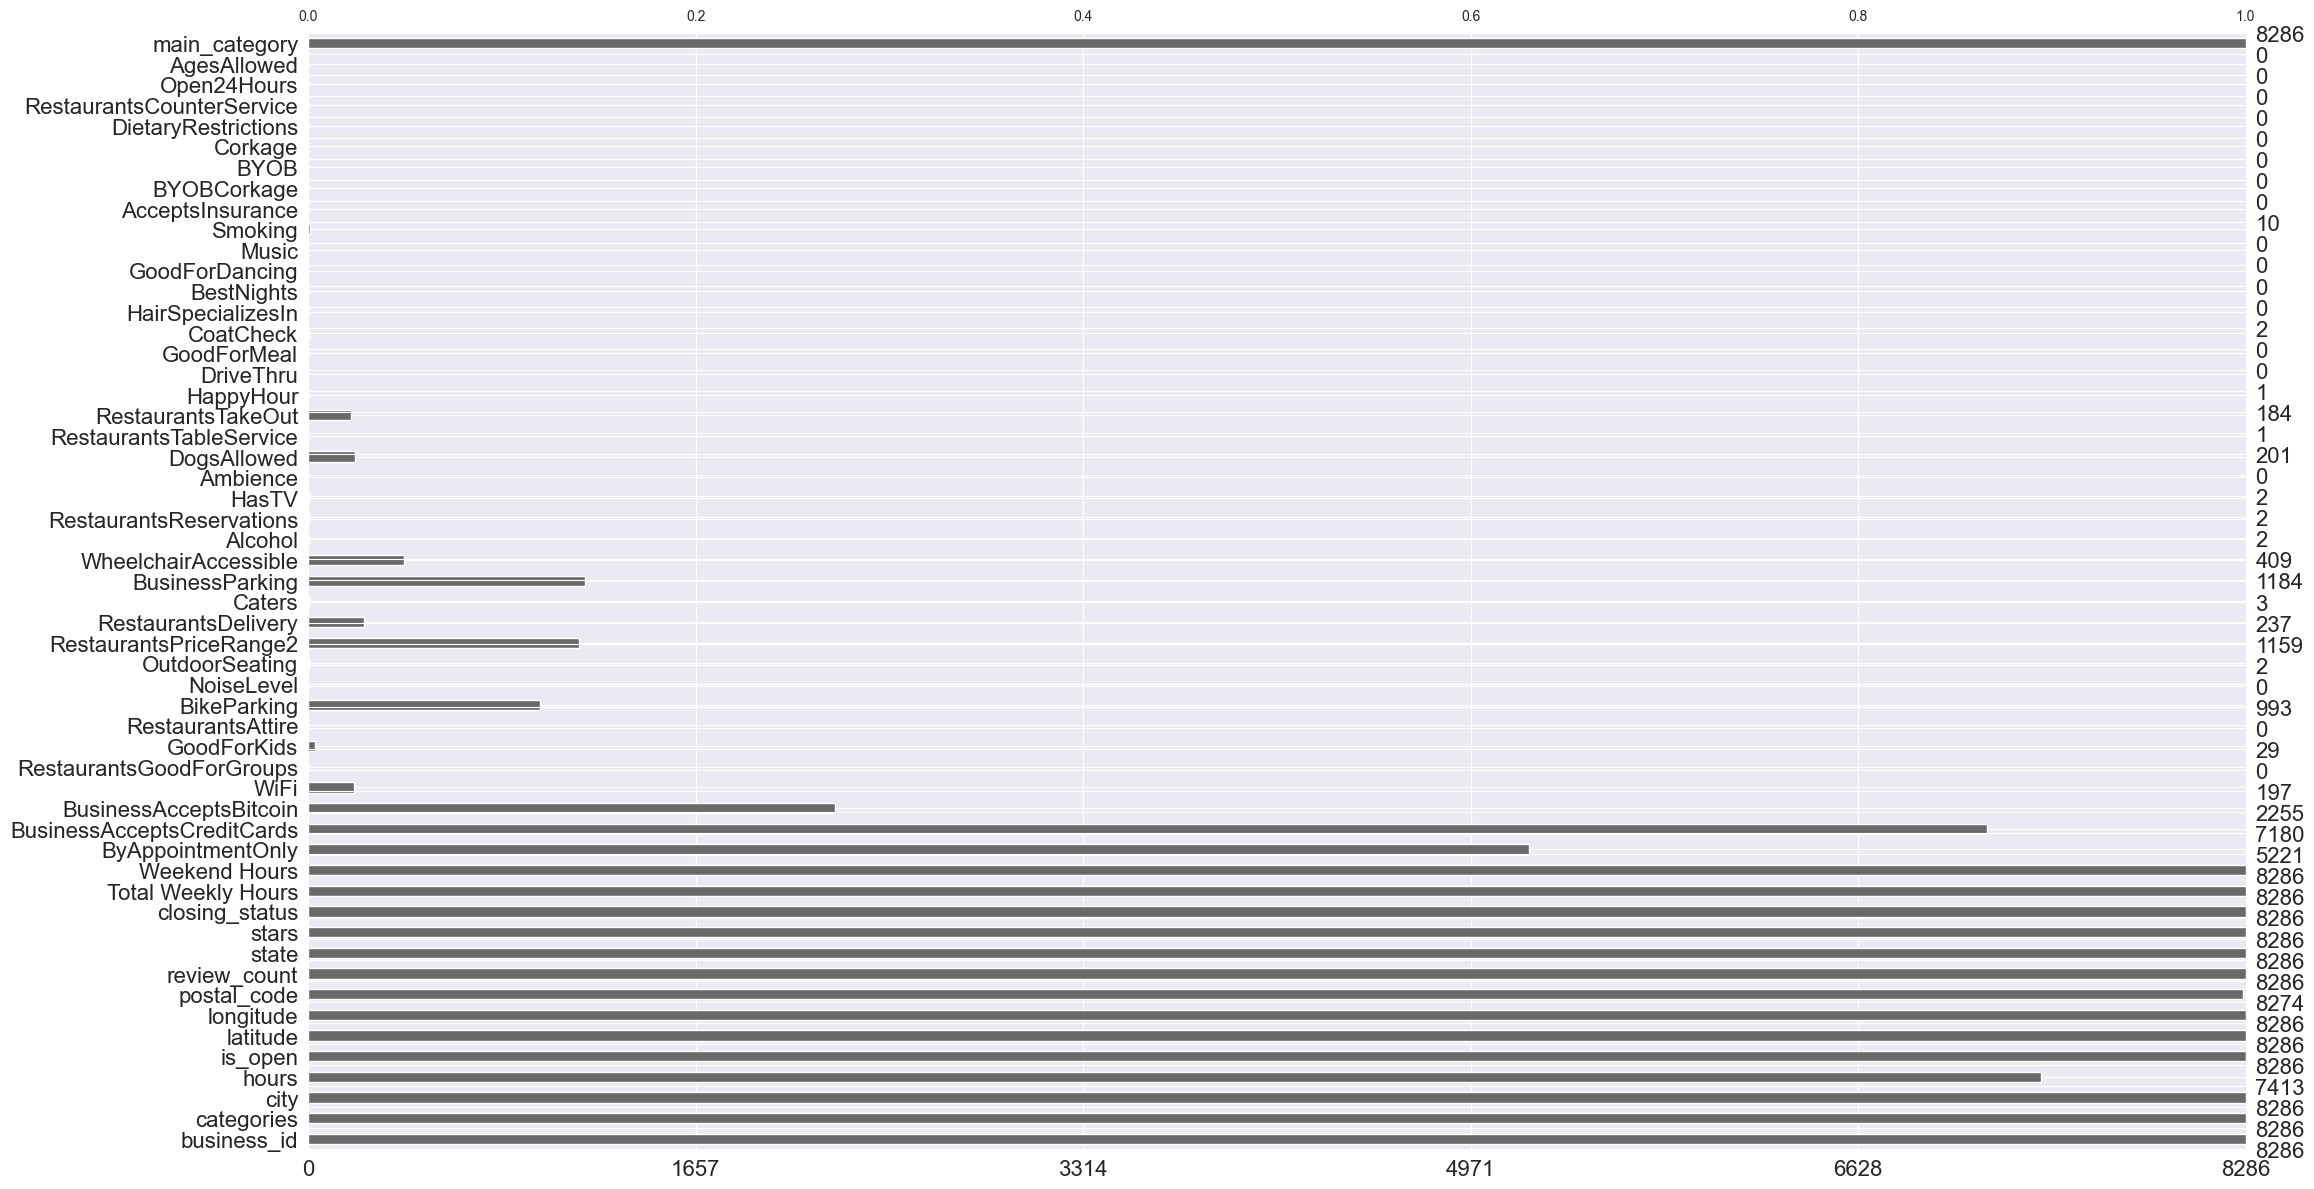

In [72]:
msno.bar(df_home_services)

##### Select columns

In [75]:
home_services_columns = ['is_open', 'review_count', 'stars', 'Weekend Hours', 'Total Weekly Hours', 'BusinessAcceptsCreditCards', 'ByAppointmentOnly']

In [76]:
df_home_services = df_home_services[home_services_columns]

In [78]:
df_home_services.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8286 entries, 0 to 120431
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   is_open                     8286 non-null   int64  
 1   review_count                8286 non-null   int64  
 2   stars                       8286 non-null   float64
 3   Weekend Hours               8286 non-null   bool   
 4   Total Weekly Hours          8286 non-null   float64
 5   BusinessAcceptsCreditCards  7180 non-null   object 
 6   ByAppointmentOnly           5221 non-null   object 
dtypes: bool(1), float64(2), int64(2), object(2)
memory usage: 461.2+ KB


In [77]:
df_home_services.head()

,is_open,review_count,stars,Weekend Hours,Total Weekly Hours,BusinessAcceptsCreditCards,ByAppointmentOnly
0,1,11,5.0,True,48.00,True,True
2,1,6,4.0,True,60.00,True,False
5,1,37,4.5,False,41.25,True,False
14,1,7,5.0,True,91.00,False,False
23,0,6,1.5,False,0.00,True,True


In [79]:
df_home_services['BusinessAcceptsCreditCards'].unique()

array(['True', 'False', nan, 'None'], dtype=object)

In [80]:
for col in df_home_services.columns:
    df_home_services[col] = df_home_services[col].replace('None', np.nan).replace(True, 1).replace(False, 0).replace('True', 1).replace('False', 0)

In [81]:
df_home_services.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8286 entries, 0 to 120431
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   is_open                     8286 non-null   int64  
 1   review_count                8286 non-null   int64  
 2   stars                       8286 non-null   float64
 3   Weekend Hours               8286 non-null   int64  
 4   Total Weekly Hours          8286 non-null   float64
 5   BusinessAcceptsCreditCards  7174 non-null   float64
 6   ByAppointmentOnly           5210 non-null   float64
dtypes: float64(4), int64(3)
memory usage: 517.9 KB


In [82]:
#
df_home_services.ByAppointmentOnly.value_counts()

ByAppointmentOnly
1.0    3050
0.0    2160
Name: count, dtype: int64

In [85]:
df_home_services.BusinessAcceptsCreditCards.value_counts()

BusinessAcceptsCreditCards
1.0    6284
0.0     890
Name: count, dtype: int64

In [84]:
df_home_services.ByAppointmentOnly.fillna(1.0, inplace=True)

In [86]:
df_home_services.BusinessAcceptsCreditCards.fillna(1.0, inplace=True)

In [88]:
# Home Service Features
features_home_service = df_home_services.drop(columns=['stars'])

# Independent variables
X_home_services = pd.get_dummies(features_home_service, drop_first=True)

# Dependent variable
y_home_services = df_home_services['stars']

In [89]:
X_sm_home_services = sm.add_constant(X_home_services)

In [90]:
model_home_services = sm.OLS(y_home_services, X_sm_home_services).fit()

In [91]:
print(model_home_services.summary())

                            OLS Regression Results                            
Dep. Variable:                  stars   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     43.18
Date:                Mon, 12 Aug 2024   Prob (F-statistic):           3.24e-52
Time:                        05:49:30   Log-Likelihood:                -12353.
No. Observations:                8286   AIC:                         2.472e+04
Df Residuals:                    8279   BIC:                         2.477e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

## **Model Development**

In [4]:
df.isnull().sum() / df.shape[0] * 100

attributes       9.336001
business_id      0.000000
categories       0.071407
city             0.000000
hours           17.069505
is_open          0.000000
latitude         0.000000
longitude        0.000000
postal_code      0.068085
review_count     0.000000
state            0.000000
stars            0.000000
dtype: float64

In [3]:
df.shape[0]

120437

In [20]:
df.head()

,attributes,business_id,categories,city,hours,is_open,latitude,longitude,postal_code,review_count,state,stars,closing_status,main_category
0,"{'ByAppointmentOnly': 'True', 'BusinessAccepts...",922049,"Home Organization, Interior Design, Profession...",Portland,"{'Monday': '0:0-0:0', 'Tuesday': '9:0-17:0', '...",1,45.551736,-122.552248,97220,11,OR,5.0,closed on 1 week day(s),Home Services
1,"{'WiFi': ""u'free'"", 'RestaurantsGoodForGroups'...",492976,"Burgers, Restaurants",Portland,"{'Monday': '11:0-20:0', 'Tuesday': '11:0-21:0'...",1,45.519562,-122.675040,97204,790,OR,4.0,open all week,Restaurant
2,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...",125987,"Home Services, Tree Services, Landscaping",Austin,"{'Monday': '8:0-18:0', 'Tuesday': '8:0-18:0', ...",1,30.296603,-97.970185,78738,6,TX,4.0,open all week,Home Services
3,{'ByAppointmentOnly': 'True'},445542,"Chiropractors, Massage Therapy, Health & Medical",Portland,NaN,0,45.520668,-122.672014,97204,15,OR,5.0,unknown,Health
4,"{'ByAppointmentOnly': 'True', 'BusinessAccepts...",225939,"Apartments, Real Estate, Home Services",Orlando,"{'Monday': '9:0-18:0', 'Tuesday': '10:0-18:0',...",0,28.520020,-81.457009,32811,7,FL,4.5,open all week,Real Estate


#### Select Column 

In [21]:
df_new = df[["main_category", "stars", "review_count", "is_open", "closing_status"]]

In [22]:
df_new.head()

,main_category,stars,review_count,is_open,closing_status
0,Home Services,5.0,11,1,closed on 1 week day(s)
1,Restaurant,4.0,790,1,open all week
2,Home Services,4.0,6,1,open all week
3,Health,5.0,15,0,unknown
4,Real Estate,4.5,7,0,open all week


In [26]:
df_new['closing_status'] = df_new['closing_status'].replace('unknown', np.nan)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_4652\783219513.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['closing_status'] = df_new['closing_status'].replace('unknown', np.nan)


,main_category,stars,review_count,is_open,closing_status


#### Prepare data for Model Development

In [25]:
df_new.shape

(120437, 5)

In [27]:
df_new.isnull().sum()

main_category         0
stars                 0
review_count          0
is_open               0
closing_status    20558
dtype: int64

In [28]:
df_new.dropna(inplace=True)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_4652\2622601097.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.dropna(inplace=True)


In [29]:
df_new.isnull().sum()

main_category     0
stars             0
review_count      0
is_open           0
closing_status    0
dtype: int64

In [31]:
features = df_new.drop(columns=['stars'])

In [32]:
X = pd.get_dummies(features, columns=['main_category', 'closing_status'], drop_first=True)

In [33]:
y = df_new['stars']

In [34]:
X.head()

,review_count,is_open,main_category_Education,main_category_Entertainment,main_category_Fitness,main_category_Health,main_category_Home Services,main_category_Other,main_category_Real Estate,main_category_Restaurant,main_category_Retail,closing_status_closed on 2 week day(s),closing_status_closed on 3 week day(s),closing_status_closed on 4 week day(s),closing_status_closed on 5 week day(s),closing_status_closed on saturday,closing_status_closed on sunday,closing_status_closed on week-ends,closing_status_open all week
0,11,1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
1,790,1,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True
2,6,1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True
4,7,0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True
5,37,1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True


In [38]:
for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = X[col].astype('int')

In [39]:
X.head()

,review_count,is_open,main_category_Education,main_category_Entertainment,main_category_Fitness,main_category_Health,main_category_Home Services,main_category_Other,main_category_Real Estate,main_category_Restaurant,main_category_Retail,closing_status_closed on 2 week day(s),closing_status_closed on 3 week day(s),closing_status_closed on 4 week day(s),closing_status_closed on 5 week day(s),closing_status_closed on saturday,closing_status_closed on sunday,closing_status_closed on week-ends,closing_status_open all week
0,11,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,790,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,6,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,7,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
5,37,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
